In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
from window_generator import WindowGenerator
from seaborn import violinplot

np.set_printoptions(precision = 4)

2023-01-25 16:54:19.441824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def queryRangePostCode(df_power, consumption_range_kwh = 2000, post_code = "81737", rank_range = None) -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        if rank_range != None:
            res = res.loc[(res["rank"] >= rank_range[0]) & (res["rank"] <= rank_range[1])]

        #Aggregating for mean household prices per day 
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [3]:
path_clean_power = "./data/master_competitor_market_prices_power.csv"
path_master_market = "./data/master_market.csv"

dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str, "rank": np.float16}
usecols = [name for name, _ in dtypes.items()]

household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)
market = pd.read_csv(path_master_market, header = [0], parse_dates=["date"]).drop("Unnamed: 0", axis=1)

market.set_index("date", inplace = True)
market.interpolate(method = "time", axis = 0, inplace = True)
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])
postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [4]:
df = queryRangePostCode(household, 3500, "12627", rank_range=[6,10])
input = df.join(market[["d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
input.drop(["2022-10-14", "2022-10-15"], inplace=True)

In [5]:
input.head()

,price_kwh,d01,d02,M01,M02,M03,q01,q02,y01,y02
valid_range,,,,,,,,,,
2021-08-14,0.292291,0.06194,0.06760,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-15,0.292291,0.06760,0.05739,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-16,0.292291,0.05739,0.08208,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-17,0.292291,0.07864,0.09236,0.09737,0.09948,0.10650,0.10263,0.10161,0.08476,0.07125
2021-08-18,0.292291,0.09162,0.10767,0.09556,0.09778,0.10595,0.10142,0.10101,0.08413,0.07120


In [7]:
norm_layer = tf.keras.layers.Normalization(axis = 1)
norm_layer.adapt(input.to_numpy())
norm_input = norm_layer(input.to_numpy())

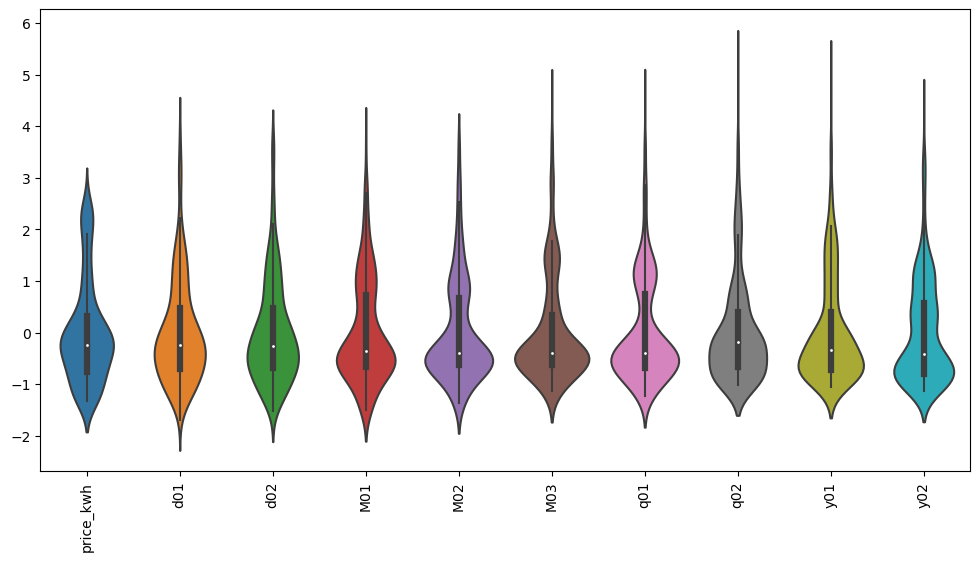

In [8]:
plt.figure(figsize=(12, 6))
ax = violinplot(data=norm_input)
_ = ax.set_xticklabels(input.keys(), rotation=90)

In [273]:
norm_input.numpy().shape

(426, 10)

<AxesSubplot: xlabel='valid_range'>

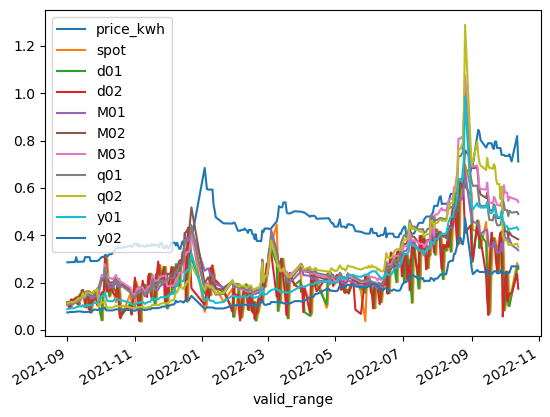

In [59]:
input.plot()

In [5]:
n = len(input)
train_df = input[:int(0.8*n)]
val_df = input[int(0.8*n):int(0.95*n)]
test_df = input[int(0.95*n):]

In [8]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(340, 10)
(64, 10)
(22, 10)


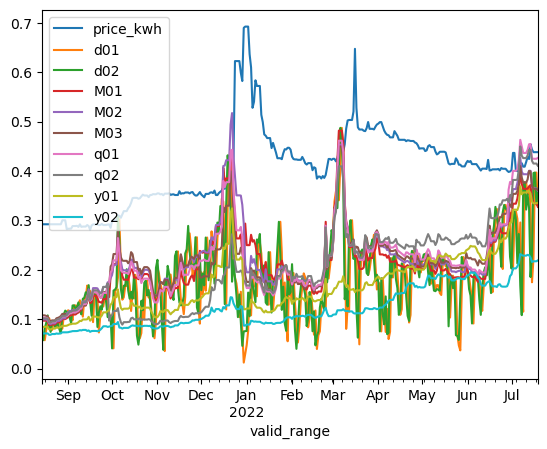

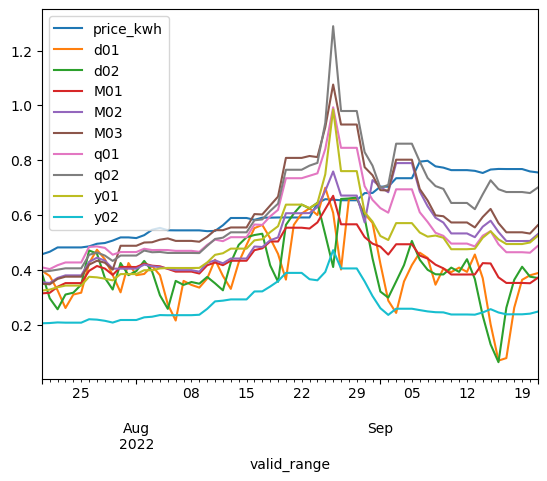

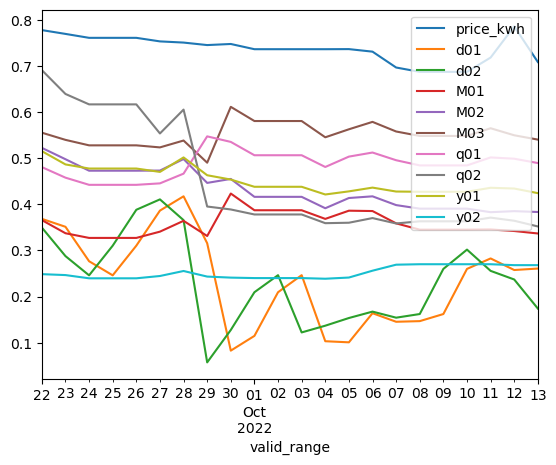

In [9]:
for df in [train_df, val_df, test_df]:
    df.plot()

In [592]:
# mean = train_df.mean()
# std = train_df.std()

# train_df = (train_df - mean) / std
# val_df = (val_df - mean) / std
# test_df = (test_df - mean) / std

# df_std = (input - mean) / std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(input.keys(), rotation=90)

# Baseline

In [6]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['price_kwh'], train_df=train_df, val_df=val_df, test_df=test_df)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['price_kwh']

In [7]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [8]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=1)

2023-01-25 13:50:55.590021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 13:50:55.644912: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1/1 [==============================] - 0s 68ms/step - loss: 6.2641e-04 - mean_squared_error: 6.2641e-04


In [9]:
print(performance, val_performance)

{'Baseline': [0.0006264105904847383, 0.0006264105904847383]} {'Baseline': [0.000192527353647165, 0.000192527353647165]}


# Linear Model

In [10]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation = None)
])

In [11]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 10)
Output shape: (32, 1, 1)


In [12]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    verbose = 1)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=early_stopping, verbose = 0)
  return history

In [13]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 3: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 0.0712 - mean_squared_error: 0.0712


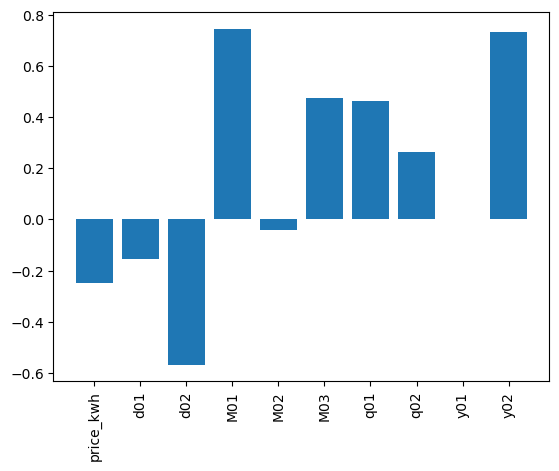

In [14]:
#Print weights of linear model
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [15]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 0.0362 - mean_squared_error: 0.0362


In [16]:
performance

{'Baseline': [0.0006264105904847383, 0.0006264105904847383],
 'Linear': [0.008168872445821762, 0.008168872445821762],
 'Dense': [0.014689277857542038, 0.014689277857542038]}

# Multi Step Dense

In [17]:
CONV_WIDTH = 10
my_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=CONV_WIDTH,
    shift=1,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

my_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['price_kwh']

In [18]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [19]:
print('Input shape:', my_window.example[0].shape)
print('Output shape:', multi_step_dense(my_window.example[0]).shape)


Input shape: (32, 10, 10)
Output shape: (32, 1, 1)


In [20]:
history = compile_and_fit(multi_step_dense, my_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(my_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(my_window.test, verbose=0)


Epoch 10: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035    


In [21]:
performance

{'Baseline': [0.0006264105904847383, 0.0006264105904847383],
 'Linear': [0.008168872445821762, 0.008168872445821762],
 'Dense': [0.014689277857542038, 0.014689277857542038],
 'Multi step dense': [0.0010164730483666062, 0.0010164730483666062]}

# Convolutional Model

In [22]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [23]:
print("Conv model on `conv_window`")
print('Input shape:', my_window.example[0].shape)
print('Output shape:', conv_model(my_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 10, 10)
Output shape: (32, 1, 1)


In [24]:
history = compile_and_fit(conv_model, my_window)

val_performance['Conv'] = conv_model.evaluate(my_window.val)
performance['Conv'] = conv_model.evaluate(my_window.test, verbose=0)


2/2 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017


In [25]:
performance

{'Baseline': [0.0006264105904847383, 0.0006264105904847383],
 'Linear': [0.008168872445821762, 0.008168872445821762],
 'Dense': [0.014689277857542038, 0.014689277857542038],
 'Multi step dense': [0.0010164730483666062, 0.0010164730483666062],
 'Conv': [0.0016847600927576423, 0.0016847600927576423]}

# LSTM Model

In [26]:
CONV_WIDTH = 10
my_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

my_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['price_kwh']

In [27]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [28]:
print('Input shape:', my_window.example[0].shape)
print('Output shape:', lstm_model(my_window.example[0]).shape)

Input shape: (32, 10, 10)
Output shape: (32, 1)


In [29]:
history = compile_and_fit(lstm_model, my_window)

val_performance['LSTM'] = lstm_model.evaluate(my_window.val)
performance['LSTM'] = lstm_model.evaluate(my_window.test, verbose=0)

Epoch 7: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060


#  LSTM + Dense

In [240]:
lstm_DNN_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(16),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [249]:
myhistory = compile_and_fit(lstm_DNN_model, my_window)

val_performance['LSTM+Dense'] = lstm_DNN_model.evaluate(my_window.val)
performance['LSTM+Dense'] = lstm_DNN_model.evaluate(my_window.test)

Epoch 5: early stopping
1/1 [==============================] - 0s 111ms/step - loss: 0.0078 - mean_squared_error: 0.0078


# Performance comparisson

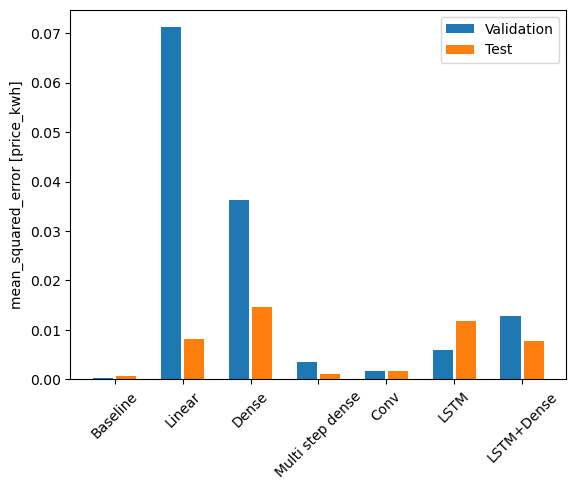

In [250]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_squared_error [price_kwh]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [33]:
performance

{'Baseline': [0.0006264105904847383, 0.0006264105904847383],
 'Linear': [0.008168872445821762, 0.008168872445821762],
 'Dense': [0.014689277857542038, 0.014689277857542038],
 'Multi step dense': [0.0010164730483666062, 0.0010164730483666062],
 'Conv': [0.0016847600927576423, 0.0016847600927576423],
 'LSTM': [0.011822600848972797, 0.011822600848972797],
 'LSTM+Dense': [0.009020473808050156, 0.009020473808050156]}

In [34]:
lstm_model.metrics_names

['loss', 'mean_squared_error']

In [35]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.0006
Linear      : 0.0082
Dense       : 0.0147
Multi step dense: 0.0010
Conv        : 0.0017
LSTM        : 0.0118
LSTM+Dense  : 0.0090


# Plot timeseries

In [236]:
def predict_with_date(self: tf.keras.Model, window: WindowGenerator, df) -> pd.DataFrame:
    model_input = window.make_dataset(df)
    predictions = self.predict(model_input, verbose = 0)
    dates = df.index[slice(window.input_width,None)]
    return pd.DataFrame(predictions[:,predictions.shape[1]-1].flatten()).set_index(dates)
tf.keras.Model.predict_with_date = predict_with_date

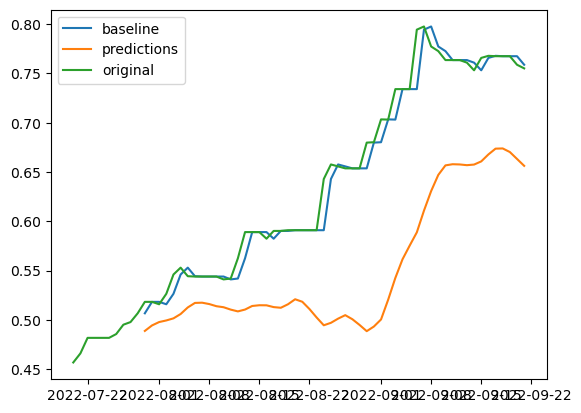

In [258]:
window = my_window
model = lstm_DNN_model
plot_data = val_df

plt.plot(baseline.predict_with_date(window = window, df = plot_data), label = "baseline")
plt.plot(model.predict_with_date(window = window, df = plot_data), label = "predictions")
plt.plot(plot_data["price_kwh"], label = "original")
plt.legend()

In [ ]:
def reverse_normalization(df):
    return df*std["price_kwh"]+mean["price_kwh"]